## TL;DR
This notebook shows how to add/change attributes by processing an event log in XES format. Specifically we add a new attribute related to loan amount and anonymize some resource IDs.

In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [2]:
from opyenxes.data_in.XUniversalParser import XUniversalParser
from opyenxes.data_out.XesXmlGZIPSerializer import XesXmlGZIPSerializer

In [3]:
xlog_fp = './data/BPIC2012-200.xes.gz'

with open(xlog_fp, 'r') as f:
    xlog = XUniversalParser().parse(f)[0]

In [4]:
required_amts = []
caseids = []

for trace in xlog:
    amt = trace.get_attributes()['AMOUNT_REQ'].get_value()
    required_amts.append(amt)
    
    caseid = int(trace.get_attributes()['concept:name'].get_value())
    caseids.append(caseid)

amt_df = pd.DataFrame({
    'caseid': caseids,
    'amount': required_amts
})

## Distribution of loan amounts in terms of counts

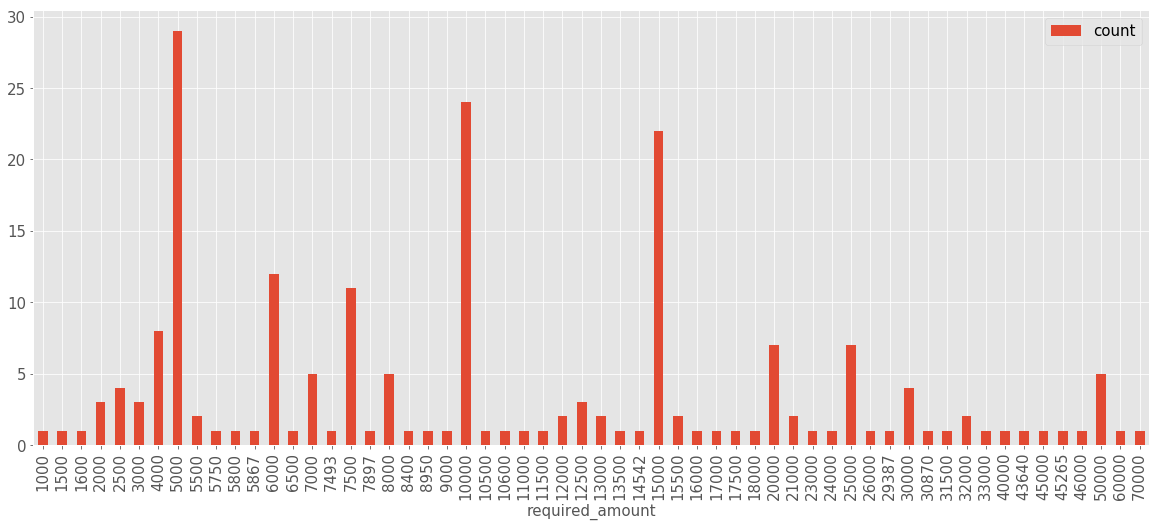

In [5]:
grouped_amt_df = amt_df['amount'].value_counts().reset_index()
grouped_amt_df = grouped_amt_df.rename({'index': 'required_amount', 'amount': 'count'}, axis=1)
grouped_amt_df.sort_values('required_amount', inplace=True)
fig, ax = plt.subplots(figsize=(20, 8))

grouped_amt_df.plot(kind='bar', x='required_amount', ax=ax);

## Create a new feature that bins the loan amount

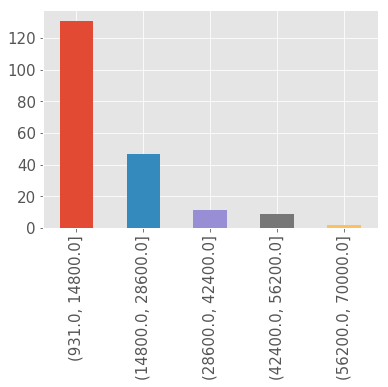

In [6]:
binned_amt_df = pd.cut(amt_df['amount'], bins=5).reset_index()
binned_amt_df['caseid'] = amt_df['caseid']
binned_amt_df['amount'].value_counts().plot(kind='bar', x='amount');

In [7]:
from opyenxes.factory.XFactory import XFactory

In [8]:
for xtrace in xlog:
    # create new attribute
    key = 'amount_cat'
    caseid = int(trace.get_attributes()['concept:name'].get_value())
    val = binned_amt_df.loc[(binned_amt_df['caseid']==caseid), 'amount'].values[0]
    amount_cat_attrib = XFactory.create_attribute_literal(key, val)
    xtrace.get_attributes()[key] = amount_cat_attrib

## Anonymize all the resources with an odd id

In [9]:
for trace in xlog:
    
    for event in trace:
        resource_attrib = event.get_attributes()['org:resource']

        if float(resource_attrib.get_value()) % 2 == 1:
            resource_attrib.set_value('UNKNOWN')

In [10]:
out_fp = './data/BPIC2012-200-processed.xes.gz'

with open(out_fp, 'w') as f:
    XesXmlGZIPSerializer().serialize(xlog, f)

Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (649.004150390625 msec.)



In [11]:
%%bash
dtrx ./data/BPIC2012-200-processed.xes.gz
mv BPIC2012-200-processed.xes ./data/
tail ./data/BPIC2012-200-processed.xes -n 79

	<trace>
		<date key="REG_DATE" value="2011-10-03T21:47:56.655"/>
		<string key="concept:name" value="174297"/>
		<int key="AMOUNT_REQ" value="30870"/>
		<string key="amount_cat" value="(28600.0, 42400.0]"/>
		<event>
			<string key="org:resource" value="112"/>
			<string key="lifecycle:transition" value="COMPLETE"/>
			<string key="concept:name" value="A_SUBMITTED"/>
			<date key="time:timestamp" value="2011-10-03T21:47:56.656"/>
		</event>
		<event>
			<string key="org:resource" value="112"/>
			<string key="lifecycle:transition" value="COMPLETE"/>
			<string key="concept:name" value="A_PARTLYSUBMITTED"/>
			<date key="time:timestamp" value="2011-10-03T21:47:57.431"/>
		</event>
		<event>
			<string key="org:resource" value="112"/>
			<string key="lifecycle:transition" value="SCHEDULE"/>
			<string key="concept:name" value="W_Afhandelen leads"/>
			<date key="time:timestamp" value="2011-10-03T21:48:22.706"/>
		</event>
		<event>
			<string key="org:resource" value="nan"/>
			<string 